Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Check GPU
#### To confirm if GPU is detected and working fine

In [1]:
!nvidia-smi

Wed Sep 14 11:03:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    21W /  N/A |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Print tensorflow version
print(tf.__version__)

2.10.0


In [4]:
# To suppress the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# changing the max_rows value to for better visualization
#pd.set_option("display.max_rows", 5)

In [6]:
# Since I am working on my personal laptop, this block is not required, so commenting it out

# If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

#Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Unzip the Data
#### Note - Run only 1st time, no need to unzip again

In [7]:
# Since `unzip` command in windows plaform doesn't work, switching to `zipfile`
#!unzip CNN_assignment.zip

import zipfile

zip_ref = zipfile.ZipFile("CNN_assignment.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [8]:
# Since `ls` command doesnt work in windows, I will have to use `os.listdir()
#!ls
os.listdir()

['.ipynb_checkpoints',
 'Atul_Melanoma_CNN_Assignment.ipynb',
 'CNN_assignment.zip',
 'README.md',
 'Skin cancer ISIC The International Skin Imaging Collaboration']

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

#### Training Dataset

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    batch_size=batch_size,
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### Validation Dataset

In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    batch_size=batch_size,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width)
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Classes of Skin Cancer

In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

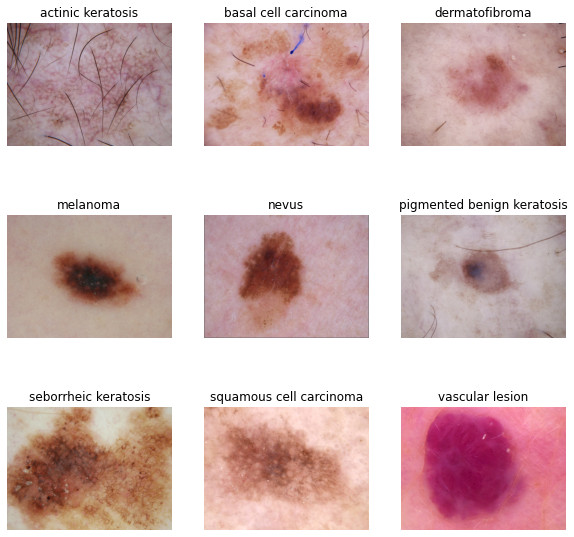

In [15]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 53ms/step - loss: 2.0332 - accuracy: 0.2299 - val_loss: 1.9126 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.9653 - accuracy: 0.2679 - val_loss: 2.0182 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.9231 - accuracy: 0.2773 - val_loss: 1.8619 - val_accuracy: 0.3199
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7542 - accuracy: 0.3410 - val_loss: 1.8277 - val_accuracy: 0.3020
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6464 - accuracy: 0.4012 - val_loss: 1.6072 - val_accuracy: 0.4228
Epoch 6/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5334 - accuracy: 0.4503 - val_loss: 1.5225 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4557 - accuracy: 0.4927 - val_loss: 1.3680 - val_accuracy: 0.5257
Epoch 8/20
56

### Visualizing training results

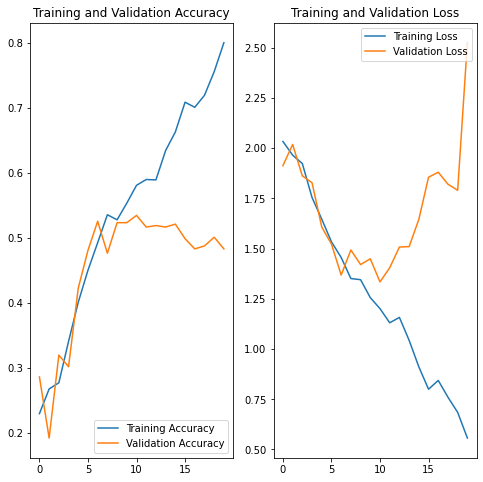

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy of Train Dataset: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss of Train Dataset: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 11ms/step - loss: 2.5249 - accuracy: 0.4832
Accuracy of Train Dataset:  0.8415178656578064
Validation Accuracy:  0.48322147130966187
Loss of Train Dataset:  0.4474799931049347
Validation Loss 2.524855136871338


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Finding on the first base model

**- It looks like the model is overfitting because as we can see the difference in accuracy and loss functions in training & test around after 10th epoch**


In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomZoom(0.15),
])

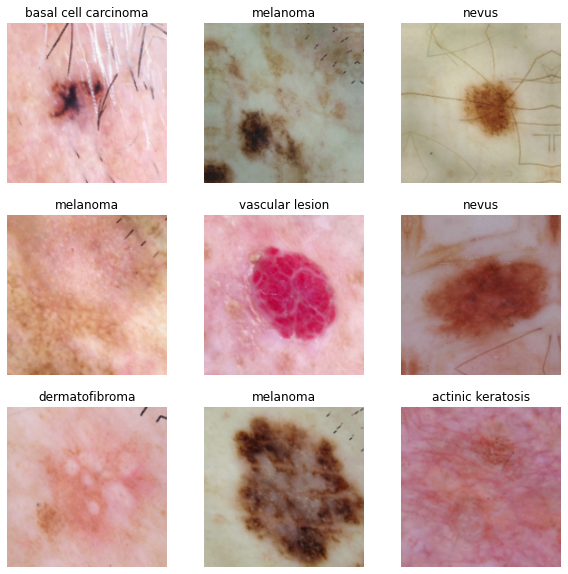

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential([data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 154ms/step - loss: 2.0457 - accuracy: 0.1981 - val_loss: 1.9710 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 8s 148ms/step - loss: 1.9502 - accuracy: 0.2667 - val_loss: 1.9204 - val_accuracy: 0.2975
Epoch 3/20
56/56 [==============================] - 8s 146ms/step - loss: 1.9104 - accuracy: 0.2801 - val_loss: 1.9424 - val_accuracy: 0.2796
Epoch 4/20
56/56 [==============================] - 8s 149ms/step - loss: 1.8514 - accuracy: 0.3030 - val_loss: 1.7953 - val_accuracy: 0.3266
Epoch 5/20
56/56 [==============================] - 8s 152ms/step - loss: 1.7421 - accuracy: 0.3499 - val_loss: 1.6815 - val_accuracy: 0.4094
Epoch 6/20
56/56 [==============================] - 8s 146ms/step - loss: 1.6879 - accuracy: 0.3873 - val_loss: 1.7565 - val_accuracy: 0.3468
Epoch 7/20
56/56 [==============================] - 8s 145ms/step - loss: 1.7189 - accuracy: 0.3610 - val_loss: 1.6093 - val_accuracy: 0.4116
Epoch

### Visualizing the results

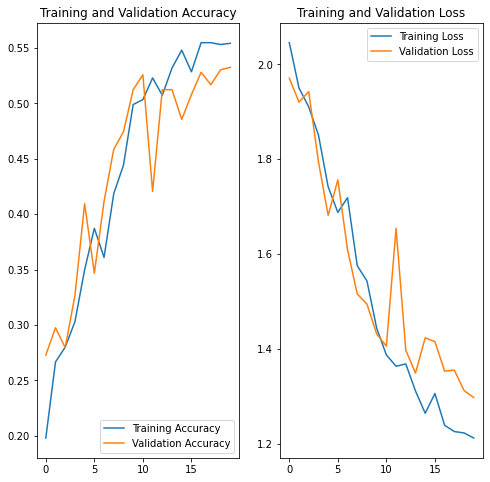

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy of Train Dataset: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss of Train Dataset: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 11ms/step - loss: 1.2974 - accuracy: 0.5324
Accuracy of Train Dataset:  0.6077008843421936
Validation Accuracy:  0.5324384570121765
Loss of Train Dataset:  1.0644923448562622
Validation Loss 1.297433614730835


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Finding from the second model

**- There is no improvement in accuracy, infact it is decreased as compared to previous model**

**- But the overfitting problem has been solved due to data augmentation** 

**- Accuracy might increase if we increase the epoch, too early to comment**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


<BarContainer object of 9 artists>

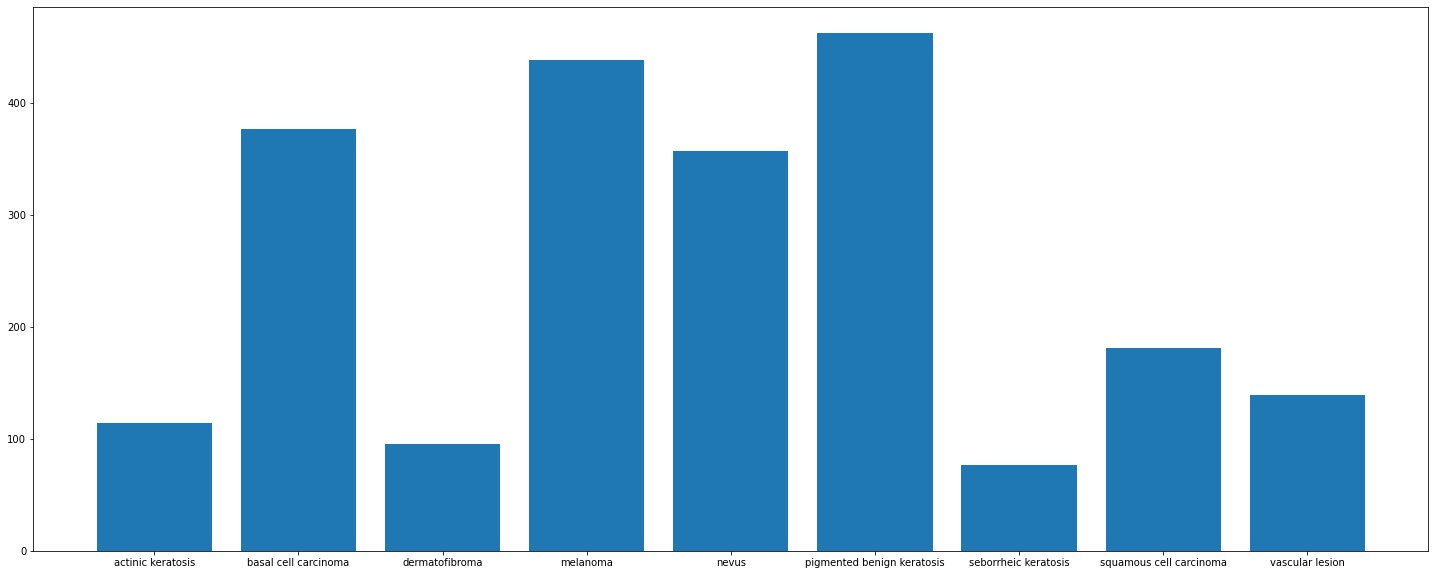

In [32]:
images_count=[]
for i in class_names:
    images_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,images_count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**Answer 1 -** `seborrheic keratosis` has the least number of samples

**Answer 2 -** `pigmented benign keratosis`, `melanoma` and `basal cell carcinoma` dominate the data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x264C738C7F0>: 100%|█| 500/500 [00:02<00:00, 200.16 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x264C5084AC0>: 100%|█| 500/500 [00:02<00:


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x264C57BFF40>: 100%|█| 500/500 [00:02<00:00, 215.48 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2635517D7F0>: 100%|█| 500/500 [00:12<00


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1007x711 at 0x26356838730>: 100%|█| 500/500 [00:11<00:00, 42.52 Samples


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2635564AAC0>: 100%|█| 500/500 [00:02<00:00, 201.93 Samples


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x264C4FD5070>: 100%|█| 500/500 [00:05<00:00, 88.42 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x264CA1D84C0>: 100%|█| 500/500 [00:02<00:00, 219.40 Samples


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26355469220>: 100%|█| 500/500 [00:02<00:00, 214.69 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
from glob import glob

# Renaming the variable `path_list` in this block to `path_list_new` after observing the next few commands in the template

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [37]:
print("New Count of Images: ", len(path_list_new))

# printing first and last entry of path_list_new just to observe the path 
res = [ path_list_new[0], path_list_new[-1] ] 
print(res)

New Count of Images:  4500
['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6cc3a61c-dc7a-4be0-bba4-1b3fa9b9eca2.jpg', 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\vascular lesion\\output\\vascular lesion_original_ISIC_0034214.jpg_b5aac20b-c28c-4440-83ea-27542cb56cf9.jpg']


In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [39]:
print("New Count of Lesions: ", len(lesion_list_new))

# printing first and last entry of lesion_list_new just to observe the lesion list 
res = [ lesion_list_new[0], lesion_list_new[-1] ] 
print(res)

New Count of Lesions:  4500
['actinic keratosis', 'vascular lesion']


In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
train_image_count_after_augmentation = len(list(data_dir_train.glob('**/*.jpg')))
print(train_image_count_after_augmentation)

6739


In [45]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential([data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

#### **Todo:**  Train your model

In [51]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 37s 161ms/step - loss: 2.0050 - accuracy: 0.2246 - val_loss: 1.7874 - val_accuracy: 0.2710
Epoch 2/50
169/169 [==============================] - 25s 150ms/step - loss: 1.6809 - accuracy: 0.3581 - val_loss: 1.5531 - val_accuracy: 0.3875
Epoch 3/50
169/169 [==============================] - 25s 146ms/step - loss: 1.5071 - accuracy: 0.4075 - val_loss: 1.4957 - val_accuracy: 0.4506
Epoch 4/50
169/169 [==============================] - 25s 148ms/step - loss: 1.4812 - accuracy: 0.4251 - val_loss: 1.4043 - val_accuracy: 0.4848
Epoch 5/50
169/169 [==============================] - 25s 148ms/step - loss: 1.4100 - accuracy: 0.4605 - val_loss: 1.3918 - val_accuracy: 0.4729
Epoch 6/50
169/169 [==============================] - 25s 147ms/step - loss: 1.3310 - accuracy: 0.4837 - val_loss: 1.2432 - val_accuracy: 0.5122
Epoch 7/50
169/169 [==============================] - 25s 148ms/step - loss: 1.2437 - accuracy: 0.5261 - val_loss: 1.1983 - val_ac

#### **Todo:**  Visualize the model results

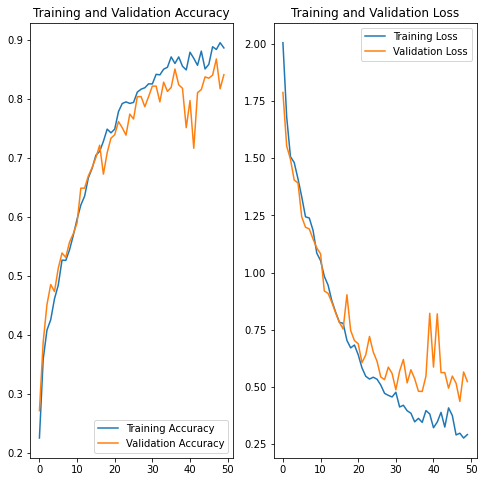

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy of Train Dataset: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss of Train Dataset: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 0s 11ms/step - loss: 0.5233 - accuracy: 0.8404
Accuracy of Train Dataset:  0.9269287586212158
Validation Accuracy:  0.8403860330581665
Loss of Train Dataset:  0.18513326346874237
Validation Loss 0.5233080387115479


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Finding from the third (final) model

**- Accuracy on training data has increased to 92.6% by using the Augmentor library**

**- Validation accuracy increased to 84% now**

**- The Model can be further improved by tuning the hyperparameter**

## Evaluation on Test Dataset

In [54]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [55]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on Test dataset")
loss_test, accuracy_test = model.evaluate(test_ds, batch_size=batch_size)

#print("test loss, test acc:", results)
print("Accuracy of Test Dataset: ", accuracy_test)
print("Loss of Test Dataset: ",loss_test)


Evaluate on Test dataset
4/4 [==============================] - 2s 78ms/step - loss: 4.9702 - accuracy: 0.4407
Accuracy of Test Dataset:  0.4406779706478119
Loss of Test Dataset:  4.9702253341674805


### Finding of evaluation of Test Dataset using the third (final) model

**- Accuracy on the unseen Test Dataset is 44.06%**

**- Although Validation accuracy of the same model was 84%**

**- The Model requires further improvement by tuning the hyperparameter**